In [30]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils import get_device, train_clf, eval_clf, test_clf
from RoBertaClassifier import RoBertaClassifier, init_roberta_clf

## Analyze dataset

In [31]:
texts_df = pd.read_csv('subtaskB_train.csv')

In [32]:
texts_df.head()

,Id,comment_text,topic,conspiracy
0,0,"Siamo davanti ad una prova, e non solo di quoz...",Qanon,1
1,1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,Covid,0
2,2,L'avete capito che non toglieranno il green pa...,Covid,0
3,3,Quindi la farsa dello spazio e della terra a ...,Terra Piatta,3
4,4,"In breve tempo, per accedere a Internet, sarà ...",Qanon,1


In [33]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            810 non-null    int64 
 1   comment_text  810 non-null    object
 2   topic         810 non-null    object
 3   conspiracy    810 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.4+ KB


0 is Covid-Conspiracy,

1 is Qanon-Conspiracy,

2 is Flat Earth-Conspiracy,

3 is Pro-Russia Conspiracy.

0    435
1    242
3     76
2     57
Name: conspiracy, dtype: int64


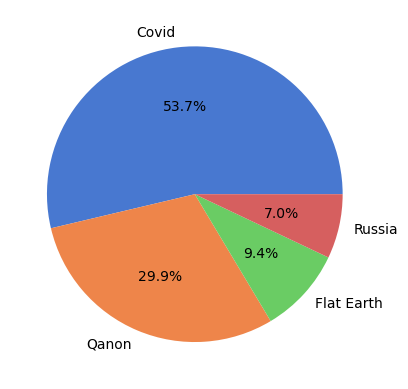

In [34]:
print(texts_df.conspiracy.value_counts())

palette = sns.color_palette('muted')
topic_labels = ['Covid', 'Qanon', 'Flat Earth', 'Russia']
plt.pie(texts_df.conspiracy.value_counts(), labels=topic_labels, autopct='%1.1f%%', colors=palette)
plt.show()

### Test set

In [35]:
texts_df_test = pd.read_csv('subtaskB_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,Ho fatto delle foto aeree ad una quota di circ...
1,1,Prof. Bellavite: tantissime persone costrette ...
2,2,"Ma si allontana.... su una terra PIATTA,......"
3,3,Non tutti gli Ukraini sono contro la Russia.\n...
4,4,Non opinioni ma dati.\n\nUno strepitoso **Giov...


In [36]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            300 non-null    int64 
 1   comment_text  300 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


## Preprocessing

Remove break line characthers

In [37]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))
texts_df_test.comment_text = texts_df_test.comment_text.apply(lambda text: str(text).replace('\n\n', ' ').replace('\n', ' '))

## Train-Validation split

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [39]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiracy):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [40]:
print(train_df.info())
print(train_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 34 to 376
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            648 non-null    int64 
 1   comment_text  648 non-null    object
 2   topic         648 non-null    object
 3   conspiracy    648 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 25.3+ KB
None
0    348
1    193
3     61
2     46
Name: conspiracy, dtype: int64


In [41]:
print(val_df.info())
print(val_df.conspiracy.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 396 to 694
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            162 non-null    int64 
 1   comment_text  162 non-null    object
 2   topic         162 non-null    object
 3   conspiracy    162 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.3+ KB
None
0    87
1    49
3    15
2    11
Name: conspiracy, dtype: int64


## Tokenization

In [42]:
from transformers import AutoTokenizer

In [43]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [44]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiracy'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiracy'].to_numpy()

texts_test = texts_df_test['comment_text']

Observe distribution of tokenized texts lengths by trying a simple tokenization on both tr and val sets.

Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


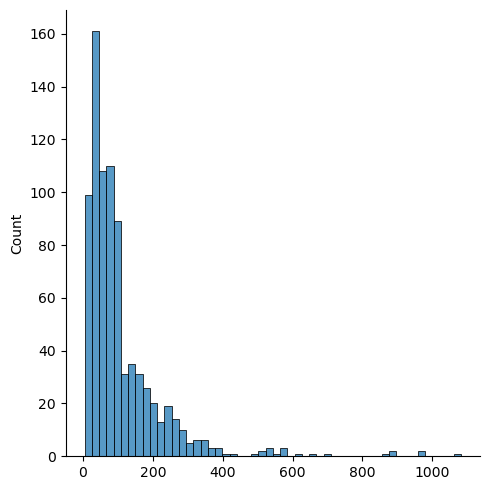

In [45]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

The maximum tokenized length is above the RoBERTa max_lenght limit of 512. For memory constraints we will use a max_lenght of 256. Also most texts are shorter than 256 tokens.

In [46]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

# Tr set
input_ids_tr = []
attention_masks_tr = []
max_sentence_len = 256

# `encode_plus` will:
#   1. Tokenize the sentence, 2. Prepend the `[CLS]` token to the start, 3. Append the `[SEP]` token to the end
#   4. Map tokens to their IDs, 5. Pad or truncate the sentence to `max_length`, 6. Create attention masks for [PAD] tokens
for sentence in texts_tr:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Val set
input_ids_val = []
attention_masks_val = []

for sentence in texts_val:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

# Test set
input_ids_test = []
attention_masks_test = []

for sentence in texts_test:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

In [47]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)
input_ids_test = torch.cat(input_ids_test, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

## Generate DataLoaders

In [48]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [49]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

The DataLoader needs to know our batch size for training. For mameory constraints, we use a lower batch size of 6.

In [50]:
batch_size = 6

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [51]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

## Training Grid Search

In [52]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [53]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

Set save folder for this run

In [54]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './checkpoints_roberta_subtaskB/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-04-26 21:21:01.043302


Fixed general hyperparams

In [55]:
max_epochs = 12

# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs
warmup_steps = 0.05*tr_steps

Variable grid searched hyperparams (smaller grid search because of time and size constraints)

In [56]:
lr_list = [6e-6, 8e-6]
clf_head_list = []

head2 = nn.Sequential(
                nn.Linear(1024, 1536),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1536, 4),
                )
clf_head_list.append((head2, '2_layers_L')) # Each head obeject is composed by a tuple (head, name)

head3 = nn.Sequential(
                nn.Linear(1024, 1536),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1536, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 4),
                )
clf_head_list.append((head3, '3_layers_L'))

Initialize, train/eval and save function for each grid search run

In [57]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth, device):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    roberta_clf_model, loss_function, optimizer, scheduler = init_roberta_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, roberta_clf_model, optimizer, scheduler = train_clf(roberta_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)

        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_clf(roberta_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'roberta_clf_{}.pt'.format(epoch_i))
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': roberta_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()

Grid Search loop

In [58]:
num_trials = len(lr_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))


for lr in lr_list:
    for clf_head_tuple in clf_head_list:            
            # Model save path subfolder
            model_folder_str = 'lr{}_head_{}'.format(lr, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, head={}'.format(lr, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth, device=device)

Executing 4 trials in grid search

Executing model with lr=6e-06, head=2_layers_L


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 1.2401147186756134 - Tr acc: 0.3966049382716049 - Tr f1: 0.21762128100736255
EVALUATION | Val Loss: 1.0988770061069064 - Val acc: 0.5370370370370371 - Val f1: 0.1746987951807229
Epoch: 1
TRAINING | Tr Loss: 0.9102548200775076 - Tr acc: 0.5987654320987654 - Tr f1: 0.298241573084009
EVALUATION | Val Loss: 0.6841029789712694 - Val acc: 0.7469135802469136 - Val f1: 0.3973615140212737
Epoch: 2
TRAINING | Tr Loss: 0.7024544881725753 - Tr acc: 0.7222222222222222 - Tr f1: 0.44679051401883363
EVALUATION | Val Loss: 0.5172423485804487 - Val acc: 0.808641975308642 - Val f1: 0.5882372061576867
Epoch: 3
TRAINING | Tr Loss: 0.4545175838974063 - Tr acc: 0.8333333333333334 - Tr f1: 0.7129517728205592
EVALUATION | Val Loss: 0.45649091713130474 - Val acc: 0.8580246913580247 - Val f1: 0.7607026143790849
Epoch: 4
TRAINING | Tr Loss: 0.2694170112911336 - Tr acc: 0.9212962962962963 - Tr f1: 0.8982455720099807
EVALUATION | Val Loss: 0.5485644501082048 - Val acc: 0.864197530864197

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 1.2856753396767158 - Tr acc: 0.404320987654321 - Tr f1: 0.18902679239461884
EVALUATION | Val Loss: 1.1410741121680648 - Val acc: 0.5370370370370371 - Val f1: 0.1746987951807229
Epoch: 1
TRAINING | Tr Loss: 1.0851481104338612 - Tr acc: 0.5432098765432098 - Tr f1: 0.19276681964651893
EVALUATION | Val Loss: 0.9425138014334219 - Val acc: 0.5370370370370371 - Val f1: 0.1746987951807229
Epoch: 2
TRAINING | Tr Loss: 0.8980425527250325 - Tr acc: 0.6373456790123457 - Tr f1: 0.3184291807302325
EVALUATION | Val Loss: 0.710023041124697 - Val acc: 0.7592592592592593 - Val f1: 0.3987108655616943
Epoch: 3
TRAINING | Tr Loss: 0.7245001125114935 - Tr acc: 0.7191358024691358 - Tr f1: 0.4320357368344985
EVALUATION | Val Loss: 0.652724059091674 - Val acc: 0.7037037037037037 - Val f1: 0.35643515060990794
Epoch: 4
TRAINING | Tr Loss: 0.5240566058567276 - Tr acc: 0.7962962962962963 - Tr f1: 0.5130117864183003
EVALUATION | Val Loss: 0.5622355235671556 - Val acc: 0.8271604938271605

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 1.1035956845239356 - Tr acc: 0.4783950617283951 - Tr f1: 0.2865510871032101
EVALUATION | Val Loss: 0.8024767306115892 - Val acc: 0.654320987654321 - Val f1: 0.3204819277108434
Epoch: 1
TRAINING | Tr Loss: 0.6008077287287624 - Tr acc: 0.7669753086419753 - Tr f1: 0.6630885122879606
EVALUATION | Val Loss: 0.34173067348698777 - Val acc: 0.8703703703703703 - Val f1: 0.8211944051548011
Epoch: 2
TRAINING | Tr Loss: 0.36778617886550447 - Tr acc: 0.8811728395061729 - Tr f1: 0.8728250081955977
EVALUATION | Val Loss: 0.4166709963853161 - Val acc: 0.8950617283950617 - Val f1: 0.8566081060255818
Epoch: 3
TRAINING | Tr Loss: 0.30689060510215954 - Tr acc: 0.9320987654320988 - Tr f1: 0.9157352987692781
EVALUATION | Val Loss: 0.3781474892705403 - Val acc: 0.8765432098765432 - Val f1: 0.8541138145431661
Epoch: 4
TRAINING | Tr Loss: 0.15950941304213806 - Tr acc: 0.9645061728395061 - Tr f1: 0.9650236103349918
EVALUATION | Val Loss: 0.4719998714712414 - Val acc: 0.8888888888888

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 1.18542824961521 - Tr acc: 0.4691358024691358 - Tr f1: 0.2662480114466334
EVALUATION | Val Loss: 1.0466302213845429 - Val acc: 0.5308641975308642 - Val f1: 0.21781517094017097
Epoch: 1
TRAINING | Tr Loss: 0.9374161070143735 - Tr acc: 0.6095679012345679 - Tr f1: 0.31251894087323284
EVALUATION | Val Loss: 0.6645378177916562 - Val acc: 0.7407407407407407 - Val f1: 0.3934108527131782
Epoch: 2
TRAINING | Tr Loss: 0.6520069833430979 - Tr acc: 0.7469135802469136 - Tr f1: 0.5521473204618697
EVALUATION | Val Loss: 0.46422354794210857 - Val acc: 0.845679012345679 - Val f1: 0.8029519807217584
Epoch: 3
TRAINING | Tr Loss: 0.3992844654109191 - Tr acc: 0.8780864197530864 - Tr f1: 0.843649125065718
EVALUATION | Val Loss: 0.4757458269941034 - Val acc: 0.8641975308641975 - Val f1: 0.7535508473008472
Epoch: 4
TRAINING | Tr Loss: 0.2479525381479309 - Tr acc: 0.9398148148148148 - Tr f1: 0.9314960394204567
EVALUATION | Val Loss: 0.41986406039170643 - Val acc: 0.8827160493827161

## Analyze grid search results

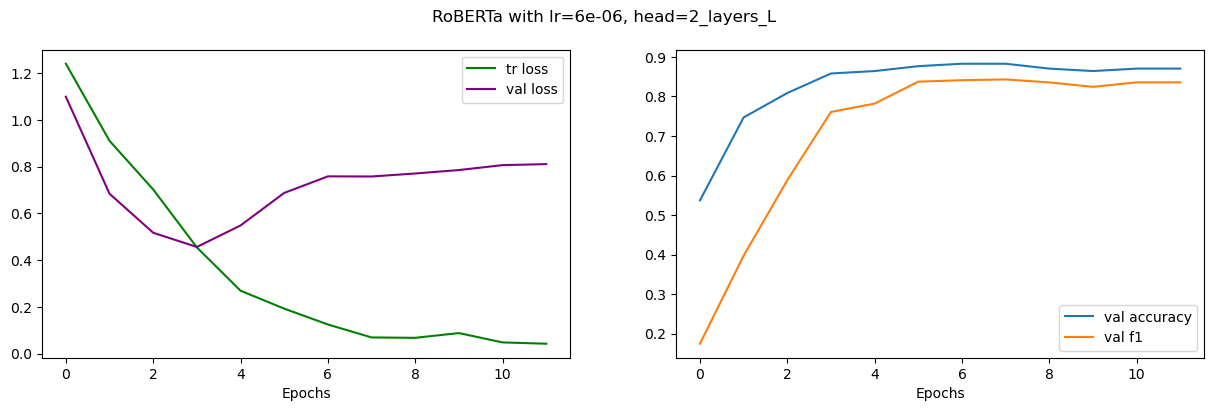

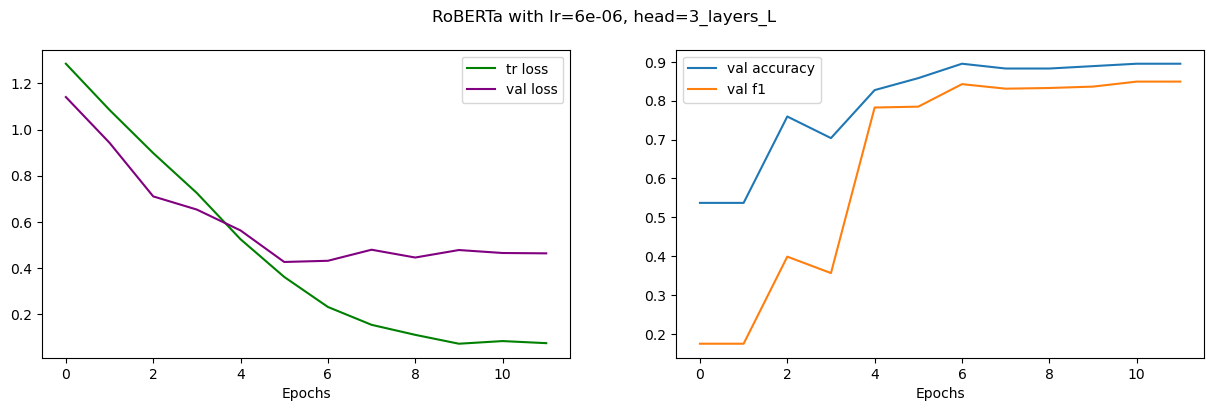

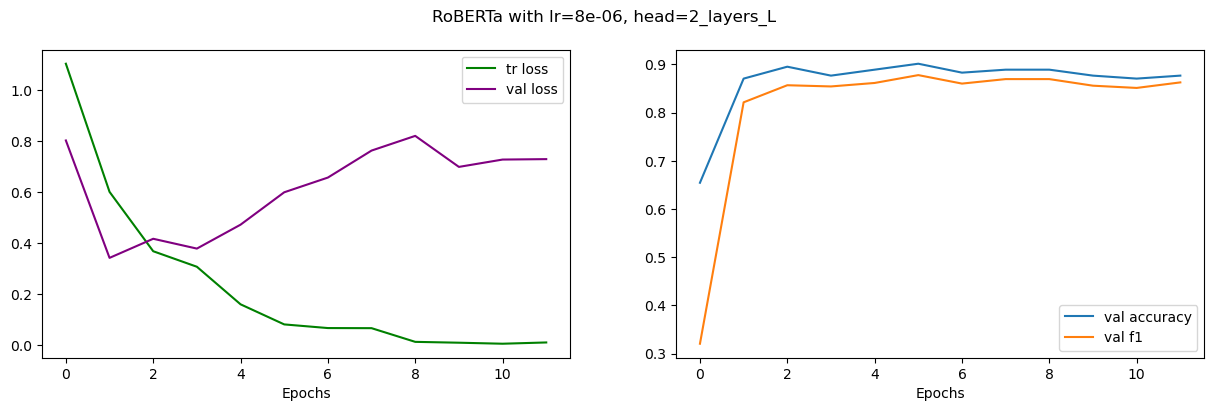

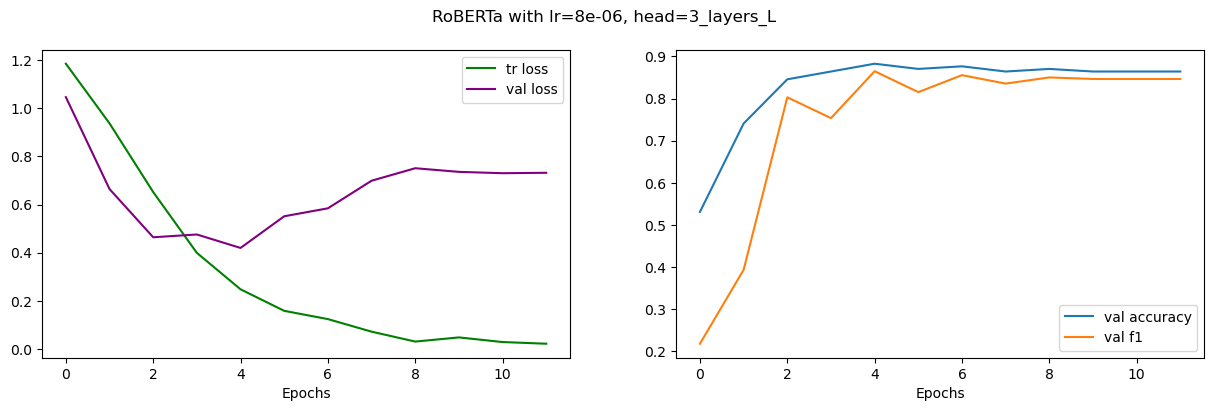

In [61]:
save_folder_pth = './checkpoints_roberta_subtaskB/26_4_2023-21.21/' # Grid search run to analyze TO CHANGE


best_f1_list = []

for lr in lr_list:
    for clf_head_tuple in clf_head_list:
            
            # Model path subfolder
            model_folder_str = 'lr{}_head_{}'.format(lr, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'RoBERTa with lr={}, head={}'.format(lr, clf_head_tuple[1])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'roberta_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()

In [62]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

RoBERTa with lr=6e-06, head=2_layers_L at epoch 7, F1: 0.8430
RoBERTa with lr=6e-06, head=3_layers_L at epoch 10, F1: 0.8491
RoBERTa with lr=8e-06, head=2_layers_L at epoch 5, F1: 0.8776
RoBERTa with lr=8e-06, head=3_layers_L at epoch 4, F1: 0.8649


## Choose and predict on test with best model

Best model is: RoBERTa with lr=8e-06, head=2_layers_L at epoch 5, F1: 0.8776

In [63]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [64]:
final_model_pth = './checkpoints_roberta_subtaskB/26_4_2023-21.21/lr8e-06_head_2_layers_L/roberta_clf_5.pt'

# Recover the best head configuration
head_2_layers_L = nn.Sequential(
                nn.Linear(1024, 1536),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1536, 4),
                )
# Initialize and recover model checkpoint
final_model = RoBertaClassifier(head=head_2_layers_L)
final_model.load_state_dict(torch.load(final_model_pth).get('model_state_dict'))

final_model.to(device)

# Prediction on test
test_preds = test_clf(final_model, test_dataloader, device)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
print(test_preds)
# print occurrences of each class
print(np.unique(test_preds, return_counts=True))

[3, 0, 3, 2, 0, 3, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 0, 3, 0, 1, 3, 1, 2, 0, 1, 0, 0, 0, 0, 1, 3, 3, 1, 3, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 1, 3, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 3, 3, 0, 0, 0, 0, 1, 3, 0, 1, 2, 3, 0, 0, 3, 0, 1, 0, 0, 2, 0, 1, 1, 3, 1, 1, 3, 1, 0, 1, 0, 0, 0, 3, 1, 1, 0, 0, 1, 2, 0, 3, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 3, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 1, 3, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 3, 3, 0, 2, 0, 1, 3, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 3, 1, 0, 2, 1, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 1, 3, 0, 0, 1, 0, 3, 0, 3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 0, 3, 0, 1, 2, 1, 0, 1, 0, 3, 1, 0, 2, 0, 3, 3, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 3, 0, 1, 3, 1]
(array([0, 1, 2, 3]), array([160,  73,  21,  46]))


Generate result CSV

In [66]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_roberta_submission_B.csv', index=False)

**RESULTS FROM KAGGLE:**

-On the 50% available hidden test set it scores 0.82106  F1 macro averaged

-On the other 50% of the test set it scores 0.88534  F1 macro averaged

-On the whole test set it scores **0.8532** F1 macro averaged